In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm

In [ ]:
# 1. 定义文件夹路径
data_root = 'data'
train_dir = os.path.join(data_root, 'training-new')
test_dir  = os.path.join(data_root, 'testing-new')

# 2. 定义预处理（以 ImageNet 预训练模型常用的 Resize/Crop/Normalize）
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_tf = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
test_tf = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# 3. 读取数据集（ImageFolder 会把每个子文件夹名当做 class 名称）
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_ds.classes)
print(f'共 {num_classes} 个类别：', train_ds.classes)


共 77 个类别： ['Apple', 'Apricot', 'Avocado', 'Banana', 'Beans', 'Beetroot', 'Blackberrie', 'Blueberry', 'Cabbage', 'Cactus fruit', 'Caju seed', 'Cantaloupe', 'Carambula', 'Carrot', 'Cauliflower', 'Cherimoya', 'Cherry', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber', 'Currant red', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Gooseberry', 'Granadilla', 'Grape', 'Grapefruit', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Onion', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepino', 'Pepper', 'Pineapple', 'Pistachio', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Pomelo Sweetie', 'Potato Red', 'Quince', 'Rambutan', 'Raspberry', 'Salak', 'Strawberry', 'Tamarillo', 'Tangelo', 'Tomato', 'Walnut', 'Watermelon', 'Zucchini']


In [ ]:

# 4. 加载模型（timm 支持 ViT-Base 和 Swin-Tiny）
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vit = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=num_classes,
    img_size=100        # ← 指定你要的输入边长
).to(device)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
model_swin = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=num_classes,
    img_size=100        # ← 指定你要的输入边长
).to(device)

/opt/anaconda3/lib/python3.11/site-packages/timm/layers/interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BucketizationUtils.h:34.)
  idx_right = torch.bucketize(x, p)


In [ ]:
# --- 模型、优化器、损失函数（同前） ---

num_classes = len(train_ds.classes)


optimizer = torch.optim.AdamW(model_vit.parameters(), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss()

# --- 记录用列表 ---
num_epochs = 10
train_losses = []
train_accuracies = []
val_accuracies = []

# --- 训练 & 验证循环 ---
for epoch in range(1, num_epochs + 1):
    # 训练
    model_vit.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_vit(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # 验证
    model_vit.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model_vit(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_accuracies.append(correct / total)

    print(f'Epoch {epoch}: loss={train_losses[-1]:.4f}, '
          f'train_acc={train_accuracies[-1]:.4f}, '
          f'val_acc={val_accuracies[-1]:.4f}')


Epoch 1: loss=1.0482, train_acc=0.7677, val_acc=0.9476
Epoch 2: loss=0.0215, train_acc=0.9950, val_acc=0.9628
Epoch 3: loss=0.0047, train_acc=0.9997, val_acc=0.9709
Epoch 4: loss=0.0010, train_acc=1.0000, val_acc=0.9730
Epoch 5: loss=0.0006, train_acc=1.0000, val_acc=0.9730
Epoch 6: loss=0.0004, train_acc=1.0000, val_acc=0.9738
Epoch 7: loss=0.0003, train_acc=1.0000, val_acc=0.9740
Epoch 8: loss=0.0003, train_acc=1.0000, val_acc=0.9740
Epoch 9: loss=0.0002, train_acc=1.0000, val_acc=0.9738
Epoch 10: loss=0.0002, train_acc=1.0000, val_acc=0.9751


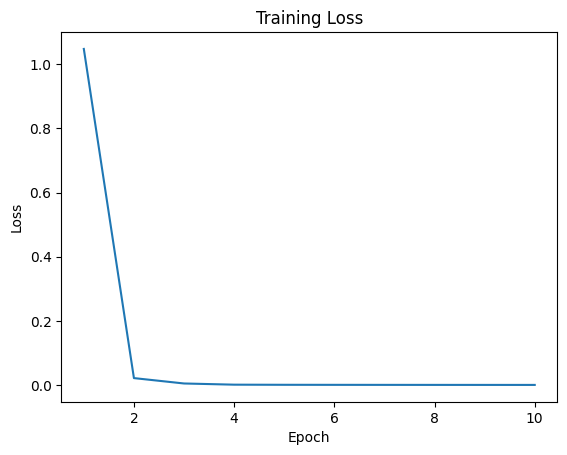

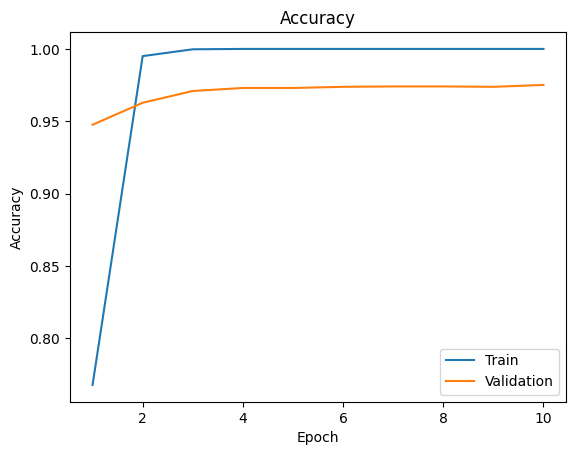

In [ ]:
import matplotlib.pyplot as plt
# --- 绘图 ---
epochs = list(range(1, num_epochs + 1))

# 训练损失曲线
plt.figure()
plt.plot(epochs, train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 准确率曲线
plt.figure()
plt.plot(epochs, train_accuracies)
plt.plot(epochs, val_accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# 1. 类别列表
class_names = train_ds.classes  # e.g. ['cat','dog',...]

# 2. 与训练一致的预处理
transform = transforms.Compose([
    transforms.Resize((100, 100)),       # 或 (224,224)，看你训练时的设置
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# 3. 载入图片并预处理
img = Image.open('data/testing-new/Cactus fruit/255_100.jpg').convert('RGB')
x   = transform(img).unsqueeze(0).to(device)  # [1,C,H,W]

# 4. 推理并取最高分标签
model_vit.eval()
with torch.no_grad():
    idx = model_vit(x).argmax(dim=1).item()

# 5. 打印结果
print(f'预测类别：{class_names[idx]}')


预测类别：Cactus fruit


In [ ]:
from sklearn.metrics import confusion_matrix
model_vit.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model_vit(imgs)
        preds = logits.argmax(dim=1).cpu()
        all_preds.extend(preds.numpy().tolist())
        all_labels.extend(labels.numpy().tolist())

In [ ]:
import numpy as np

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds, labels=range(len(train_ds.classes)))

# 每类总样本数
totals = cm.sum(axis=1)
# 每类正确数（对角线）
corrects = np.diag(cm)
# 每类准确率
acc_per_class = corrects / totals

# 按准确率从低到高排序
sorted_idx = np.argsort(acc_per_class)
print("各类准确率：")
for idx in sorted_idx:
    print(f"{train_ds.classes[idx]}: {acc_per_class[idx]:.3f} ({corrects[idx]}/{totals[idx]})")


各类准确率：
Avocado: 0.680 (34/50)
Apple: 0.688 (33/48)
Corn Husk: 0.720 (36/50)
Beetroot: 0.760 (38/50)
Pepino: 0.820 (41/50)
Pear: 0.878 (43/49)
Tomato: 0.898 (44/49)
Corn: 0.900 (45/50)
Blackberrie: 0.909 (40/44)
Eggplant: 0.940 (47/50)
Cucumber: 0.952 (40/42)
Cherry: 0.959 (47/49)
Strawberry: 0.980 (49/50)
Potato Red: 0.980 (49/50)
Peach: 1.000 (48/48)
Passion Fruit: 1.000 (50/50)
Papaya: 1.000 (50/50)
Orange: 1.000 (50/50)
Nut Pecan: 1.000 (50/50)
Nut Forest: 1.000 (50/50)
Nectarine: 1.000 (50/50)
Mulberry: 1.000 (50/50)
Melon Piel de Sapo: 1.000 (50/50)
Maracuja: 1.000 (50/50)
Mangostan: 1.000 (50/50)
Onion: 1.000 (50/50)
Walnut: 1.000 (50/50)
Pepper: 1.000 (50/50)
Tamarillo: 1.000 (50/50)
Pineapple: 1.000 (48/48)
Mango: 1.000 (50/50)
Pistachio: 1.000 (50/50)
Pitahaya Red: 1.000 (50/50)
Plum: 1.000 (50/50)
Pomegranate: 1.000 (50/50)
Pomelo Sweetie: 1.000 (50/50)
Quince: 1.000 (50/50)
Rambutan: 1.000 (50/50)
Raspberry: 1.000 (50/50)
Salak: 1.000 (50/50)
Tangelo: 1.000 (50/50)
Mandarine

In [ ]:
print("\n最差的 3 个类别：")
for idx in sorted_idx[:10]:
    print(f"{train_ds.classes[idx]}: {acc_per_class[idx]:.3f}")


最差的 3 个类别：
Avocado: 0.680
Apple: 0.688
Corn Husk: 0.720
Beetroot: 0.760
Pepino: 0.820
Pear: 0.878
Tomato: 0.898
Corn: 0.900
Blackberrie: 0.909
Eggplant: 0.940


In [ ]:
torch.save(model_vit.state_dict(), 'model/model_vit_weights.pth')

In [ ]:
#下次再使用时，先重建模型结构
# model_vit = timm.create_model(
#     'vit_base_patch16_224', pretrained=False, num_classes=num_classes, img_size=100
# )
# model_vit.load_state_dict(torch.load('model_vit_weights.pth'))
# model_vit.to(device).eval()

## swin

In [ ]:
# --- 模型、优化器、损失函数（同前） ---
optimizer = torch.optim.AdamW(model_swin.parameters(), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss()

# --- 记录用列表 ---
num_epochs = 10
train_losses = []
train_accuracies = []
val_accuracies = []

# --- 训练 & 验证循环 ---
for epoch in range(1, num_epochs + 1):
    # 训练
    model_swin.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_swin(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # 验证
    model_swin.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model_vit(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_accuracies.append(correct / total)

    print(f'Epoch {epoch}: loss={train_losses[-1]:.4f}, '
          f'train_acc={train_accuracies[-1]:.4f}, '
          f'val_acc={val_accuracies[-1]:.4f}')


Epoch 1: loss=2.5440, train_acc=0.5628, val_acc=0.9751
Epoch 2: loss=0.4864, train_acc=0.9608, val_acc=0.9751
Epoch 3: loss=0.1941, train_acc=0.9882, val_acc=0.9751
Epoch 4: loss=0.1058, train_acc=0.9963, val_acc=0.9751
Epoch 5: loss=0.0717, train_acc=0.9976, val_acc=0.9751
Epoch 6: loss=0.0457, train_acc=0.9997, val_acc=0.9751
Epoch 7: loss=0.0399, train_acc=0.9992, val_acc=0.9751
Epoch 8: loss=0.0268, train_acc=0.9997, val_acc=0.9751
Epoch 9: loss=0.0248, train_acc=1.0000, val_acc=0.9751
Epoch 10: loss=0.0180, train_acc=1.0000, val_acc=0.9751


In [ ]:
torch.save(model_swin.state_dict(), 'model/model_swin_weights.pth')

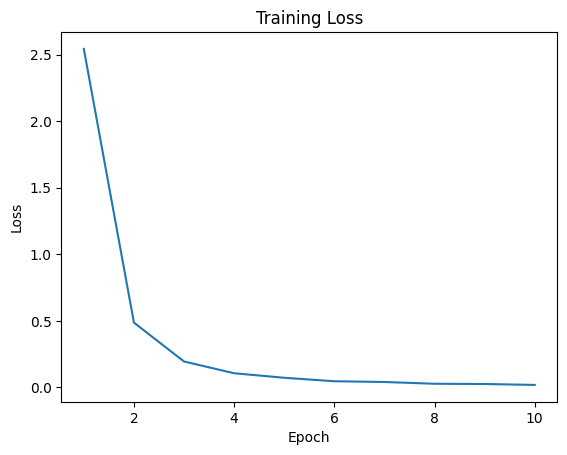

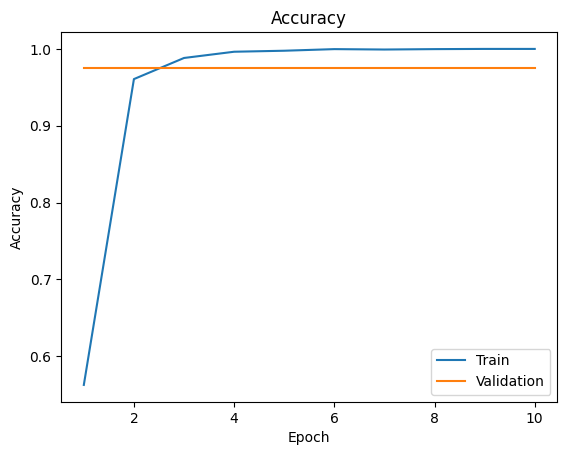

In [ ]:
import matplotlib.pyplot as plt
# --- 绘图 ---
epochs = list(range(1, num_epochs + 1))

# 训练损失曲线
plt.figure()
plt.plot(epochs, train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 准确率曲线
plt.figure()
plt.plot(epochs, train_accuracies)
plt.plot(epochs, val_accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
model_swin.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model_swin(imgs)
        preds = logits.argmax(dim=1).cpu()
        all_preds.extend(preds.numpy().tolist())
        all_labels.extend(labels.numpy().tolist())

In [ ]:
import numpy as np

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds, labels=range(len(train_ds.classes)))

# 每类总样本数
totals = cm.sum(axis=1)
# 每类正确数（对角线）
corrects = np.diag(cm)
# 每类准确率
acc_per_class = corrects / totals

# 按准确率从低到高排序
sorted_idx = np.argsort(acc_per_class)
print("各类准确率：")
for idx in sorted_idx:
    print(f"{train_ds.classes[idx]}: {acc_per_class[idx]:.3f} ({corrects[idx]}/{totals[idx]})")


各类准确率：
Avocado: 0.680 (34/50)
Corn Husk: 0.780 (39/50)
Pear: 0.796 (39/49)
Cherry: 0.796 (39/49)
Apple: 0.833 (40/48)
Tomato: 0.837 (41/49)
Pepino: 0.960 (48/50)
Eggplant: 0.980 (49/50)
Mangostan: 1.000 (50/50)
Mandarine: 1.000 (50/50)
Peach: 1.000 (48/48)
Passion Fruit: 1.000 (50/50)
Papaya: 1.000 (50/50)
Orange: 1.000 (50/50)
Onion: 1.000 (50/50)
Nut Pecan: 1.000 (50/50)
Nectarine: 1.000 (50/50)
Mulberry: 1.000 (50/50)
Melon Piel de Sapo: 1.000 (50/50)
Maracuja: 1.000 (50/50)
Mango: 1.000 (50/50)
Nut Forest: 1.000 (50/50)
Pepper: 1.000 (50/50)
Pineapple: 1.000 (48/48)
Walnut: 1.000 (50/50)
Tangelo: 1.000 (50/50)
Tamarillo: 1.000 (50/50)
Strawberry: 1.000 (50/50)
Salak: 1.000 (50/50)
Raspberry: 1.000 (50/50)
Lychee: 1.000 (50/50)
Rambutan: 1.000 (50/50)
Potato Red: 1.000 (50/50)
Pomelo Sweetie: 1.000 (50/50)
Pomegranate: 1.000 (50/50)
Plum: 1.000 (50/50)
Pitahaya Red: 1.000 (50/50)
Pistachio: 1.000 (50/50)
Quince: 1.000 (50/50)
Limes: 1.000 (50/50)
Kumquats: 1.000 (50/50)
Watermelon: 

In [ ]:
print("\n最差的 3 个类别：")
for idx in sorted_idx[:10]:
    print(f"{train_ds.classes[idx]}: {acc_per_class[idx]:.3f}")


最差的 3 个类别：
Avocado: 0.680
Corn Husk: 0.780
Pear: 0.796
Cherry: 0.796
Apple: 0.833
Tomato: 0.837
Pepino: 0.960
Eggplant: 0.980
Mangostan: 1.000
Mandarine: 1.000
